In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from pyudf.rotation import z_rotation
from tqdm.notebook import tqdm

plt.style.use("presentation")

In [3]:
def quaternionToRotationArray(q):
    return [
        [1 - 2 * (q.q2 * q.q2 + q.q3 * q.q3), 2 * (q.q1 * q.q2 + q.q0 * q.q3), 2 * (q.q3 * q.q1 - q.q0 * q.q2)],
        [2 * (q.q1 * q.q2 - q.q0 * q.q3), 1 - 2 * (q.q1 * q.q1 + q.q3 * q.q3), 2 * (q.q2 * q.q3 + q.q0 * q.q1)],
        [2 * (q.q3 * q.q1 + q.q0 * q.q2), 2 * (q.q2 * q.q3 - q.q0 * q.q1), 1 - 2 * (q.q1 * q.q1 - q.q2 * q.q2)]
    ]

In [4]:
RHO = 1.0
MU  = 1.0
a   = 5.0
h   = a / 2.0


degrees = np.linspace(0, 2*np.pi, 33)
rs      = np.array([quaternionToRotationArray(z_rotation(d))[1] for d in degrees])
n_zero  = np.zeros(33)

In [8]:
# Operation variable.
gra      = 0.06
gammadot = 0.048

# Variables for search minimum. If minimum vaule are not
# changed more than 5 times, iteration will stop.
m_min        = 10000000000000
m_index      = -1
m_gra        = -1
m_gammadot   = -1
m_n_gammadot = None
m_n_bh       = None
no_chcount   = 0

for i in tqdm(range(100000)):
    if no_chcount > 5:
        break
    gammadot += 0.0000001
    gravity    = np.array([0.0, 1.0, 0.0]) * (gra * RHO * 4 / 3 * np.pi * (a**3))
    n_gammadot = np.array([8 * np.pi * MU * (a**3) * 0.5 * gammadot] * 33)
    n_bh       = (np.cross(rs, gravity) * h)[:, -1]  # bottom heavyによるトルクのz成分を取得する。
    if abs((n_gammadot + n_bh)[8]) <= m_min:
        m_min = abs((n_gammadot + n_bh)[8])
        m_gra = gra
        m_gammadot = gammadot
        m_n_gammadot = n_gammadot
        m_n_bh = n_bh
    else:
        no_chcount += 1        

print(f'min      = {m_min}')
print(f'gammadot = {m_gammadot}')
print(f'gra      = {m_gra}')
print(f'G        = {2 / 3 * RHO * h * m_gra / MU / m_gammadot}')

min      = 9.033840342453914e-11
gammadot = 0.05000000000005751
gra      = 0.06
G        = 1.9999999999976994


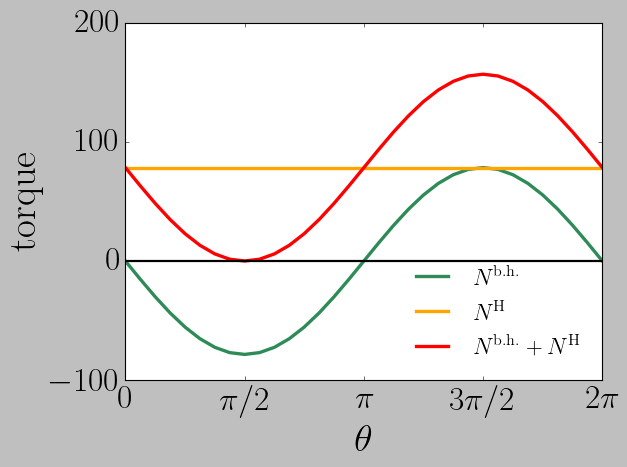

In [9]:
xticks = [d * 2 * np.pi / 4 for d in range(0, 9)]
xticks_str = ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
plt.xticks(xticks, xticks_str, fontsize=30)
plt.yticks(np.arange(-100, 201, 100), fontsize=30)
plt.ylim(-100, 200)
plt.xlabel(r'$\it{\theta}$', fontsize=35)
plt.ylabel(r'$\rm{torque}$', fontsize=35)
plt.plot(degrees, m_n_bh, label="$N^\mathrm{b.h.}$", color="seagreen", linewidth=3)
plt.plot(degrees, m_n_gammadot, label="$N^\mathrm{H}$", color="orange", linewidth=3)
plt.plot(degrees, m_n_gammadot + m_n_bh, label="$N^\mathrm{b.h.} + N^\mathrm{H}$", color="r", linewidth=3)
plt.plot(degrees, n_zero, color="k", linewidth=2)
plt.legend(loc="lower right", fontsize=21)
plt.tight_layout()
plt.savefig("../figs/sim04/theory.png")